### Kernel OMP

In [67]:
import numpy as np
import matplotlib.pyplot as plt

### Auxilliary functions
Convert an adjacency list to an adjacency matrix.
Verifyies whether a weighted adjacency matrix $W$ is a directed acyclic graph (self-loops allowed).

In [77]:
def Lambda_to_adj(Lambda):
    """Convert Lambda list to adjacency matrix"""
    p = len(Lambda)

    adj_mat = np.zeros((p, p))

    for i, col in enumerate(Lambda):
        adj_mat[i, col] = 1 

    return adj_mat

def is_dag(W_in):

    # get dimension
    p = np.shape(W_in)[0]

    # copy to modify it
    W = W_in.copy()

    # remove diagonal entries
    np.fill_diagonal(W, 0)

    order, old_order = [], list(range(p))

    # for the number of elements
    for i in range(p):

        # find a row that contains only zeros
        for j in range(p - i):

            # if we find a zero row (excl. diags)
            if not W[j].any() != 0:

                # remove this row and column
                W = np.delete(W, j, 0)
                W = np.delete(W, j, 1)

                order.append(old_order[j])
                old_order.remove(old_order[j])

                # go to next variable
                break

            # if no zero row exist stop
            elif i == p - 1:
                return False

    return True, order

### Kernel OMP
Parameters: $X$, $Y$. Data matrices such that $Y = XW$. 

In the VAR(1) case, $X = \mathbf{X}_{-1}$, $Y = \mathbf{X}_{-T}$, so $X$ has the last entry removed, and $Y$ has the first entry removed.

Stopping criteria:
- max_coefs: maximum number of non-zero coefficients. stop when this value is exceeded.
- tol_gain: maximum of gains. stop when all gains are below this tolerance.
- tol_res: maximum of residual. stop when the residual is below this tolerance.

Extra:
- verbose: prints steps at each itersion, only useful for < 10 variables.

In [78]:
def K_OMP(X, Y, max_coefs = 1e10, tol_gain = 0.0, tol_res = 0.0, verbose = False):
    """Do Kernel OMP on X, Y."""

    # get dimensions
    T, p = np.shape(X)

    # compute kernel spaces
    Psi = X.T.dot(X)                    # p times p
    K = X.T.dot(Y)                      # p times p
    Theta = [y.T.dot(y) for y in Y.T]   # p times 1

    # initialize Lambda, idx, W, Ws, F
    Lambda, idx, W, Ws, F = [[] for _ in range(p)], [], np.zeros((p, p)), [], []

    # compute norms for normalization
    norms = [np.linalg.norm(x, 2) for x in X.T]

    # for each possible coefficient
    for i in range(p ** 2):    

        # compute gains
        gains = np.abs([(k - W.T @ Psi[i, :]) / norms[i] for i, k in enumerate(K)])

        # set forbidden set to -1, impossible to pick then
        gains = gains.flatten()
        gains[F] = - np.ones(len(F))
        gains = gains.reshape(p, p)

        # stopping criterion, tolerance on gain
        if gains.max() <= tol_gain: break

        # append best atom to Lambda
        idx_max = np.argmax(gains)
        row, col = idx_max // p, idx_max % p

        if row not in Lambda[col]: Lambda[col].append(row)

        # check if we have a DAG
        if is_dag(Lambda_to_adj(Lambda)): 
            
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]

            # speedup: add transpose to forbidden set
            F.append(idx_max)
            F.append(col * p + row)

            # update W        	
            W[np.array(idx)[:, None], col] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None], col]

            # keep track of order of edges added
            Ws.append(W.copy())
            
            # stopping criterion, max number of coefficients
            if len(np.nonzero(W)[0]) >= max_coefs: break

        # if adding the edge violates dagness
        else: 
            # append forbidden entry to forbidden list
            F.append(int(idx_max))
            
            # remove coefficient from Lambda
            Lambda[col].remove(row)

        # stopping criterion, compute two norm of the residual
        if sum([Theta[i] - K[:, i] @ W[:, i] for i in range(p)]) < tol_res:
            print("Residual Limit, terminate")
            break

        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains, 3)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(W, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - K[:, i] @ W[:, i] for i in range(p)], 3)}.\n\n")

    return W, Ws

### Example

In [79]:
def generate_var(T, p, W):
    
    # Initialize series
    X = np.array(np.zeros((T, p)))
    noises = np.random.multivariate_normal(np.zeros(p), np.identity(p), T)
    
    # Generate series
    for t in range(1, T):
        X[t] = X[t - 1] @ W + noises[t]
    
    # Return series
    return X

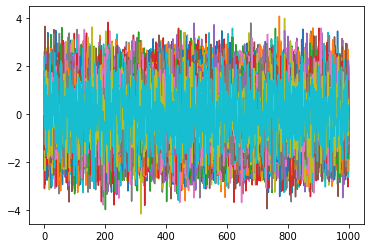

In [83]:
T, p = 1000, 100
A = np.random.rand(p, p) / (4 * p)
X = generate_var(T, p, A)
plt.plot(X)

W, Ws = K_OMP(X[:-1], X[1:], max_coefs = 200)